# Regional distribution of precipitation

### Imports

In [262]:
import sys
import os
aps_path = os.path.dirname(os.path.abspath("."))
sys.path.append(aps_path)
print(aps_path)

D:\Dev\APS\aps


In [263]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from aps_io.get_arome import nc_load

In [264]:
%matplotlib inline

In [265]:
import warnings
warnings.filterwarnings('ignore')

### Defining functions

In [266]:
def regional_precip(precip):
    pf = precip.flatten()
    pfc = np.clip(pf, 0, 1000)

    box_bot = np.nanpercentile(pfc, 25.0)
    box_top = np.nanpercentile(pfc, 75.0)
    box_center = np.nanpercentile(pfc, 50.0)
    flier_low = np.nanpercentile(pfc, 0.0) #np.min(pfc)
    flier_high = np.nanpercentile(pfc, 100.0) #np.max(pfc)
    pf_mean = np.nanmean(pfc)

    return flier_low, box_bot, box_center, box_top, flier_high

In [267]:
def regional_precip_max(precip, window_x = 20, window_y = 20, step_x = 5, step_y = 5):

    highest_med_bot = 0
    highest_med_top = 0
    highest_med_center = 0
    highest_med_low = 0
    highest_med_high = 0
    
    highest_max_bot = 0
    highest_max_top = 0
    highest_max_center = 0
    highest_max_low = 0
    highest_max_high = 0
    
    for i in range(0, precip.shape[0]-window_y, step_y):
        for j in range(0, precip.shape[1]-window_x, step_x):

            Pwin = precip[i:i+window_y, j:j+window_x]

            pf = Pwin.flatten() # make 1-D
            pfc = np.clip(pf, 0, 1000) # remove unrealistic values; should probaby be set to NaN

            box_bot = np.nanpercentile(pfc, 25.0)
            box_top = np.nanpercentile(pfc, 75.0)
            box_center = np.nanpercentile(pfc, 50.0)
            flier_low = np.nanpercentile(pfc, 0.0) #np.min(pfc) 
            flier_high = np.nanpercentile(pfc, 100.0) #np.max(pfc)
            pf_mean = np.nanmean(pfc)

            if box_center > highest_med_center:
                highest_med_bot = box_bot
                highest_med_top = box_top
                highest_med_center = box_center
                highest_med_low = flier_low
                highest_med_high = flier_high
                #print(flier_high, box_top) # there is an issue with the box_top value !!!
                med_i = i
                med_j = j
            if flier_high > highest_max_high:
                highest_max_high = flier_high
                max_i = i
                max_j = j
            #print(flier_low, box_bot, box_center, box_top, flier_high, pf_mean)
            
    return highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j


### Load region-mask

In [268]:
vr = Dataset(r"../data/terrain_parameters/VarslingsOmr_2017.nc", "r")

regions = vr.variables["VarslingsOmr_2017"][:]

region_mask = np.where(regions==3012) # Sør-Troms
# get the lower left and upper right corner of a rectangle around the region
y_min, y_max, x_min, x_max = min(sor_troms_mask[0].flatten()), max(sor_troms_mask[0].flatten()), min(sor_troms_mask[1].flatten()), max(sor_troms_mask[1].flatten())

### Read precipitation data from met_obs_grid netcdf file and clip to a subregion.

In [269]:
nc = Dataset("../data/met_obs_grid/rr_2016_12_12.nc", "r")

time_var = nc.variables['time']
precip_var = nc.variables['precipitation_amount']

In [270]:
x1, x2 = x_min, x_max # possible to add a buffer of step_x
y1, y2 = y_min, y_max # possible to add a buffer of step_y

precip = precip_var[0, y1:y2, x1:x2]

In [271]:
region_mask = regions[y1:y2, x1:x2] # redefine region_mask, now clipped to area of interest

precip = np.ma.masked_where(region_mask!=3012, precip)

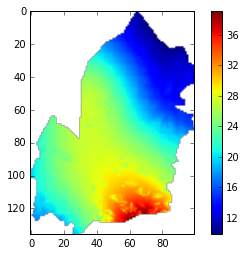

In [272]:
plt.imshow(precip, aspect='equal')
plt.colorbar()
plt.show()

0.0 13.5 21.6000003815 26.5 43.9000015259


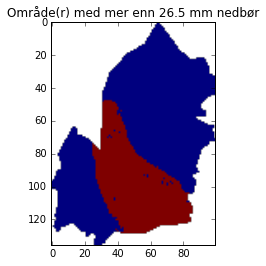

In [273]:
flier_low, box_bot, box_center, box_top, flier_high = regional_precip(precip)
print(flier_low, box_bot, box_center, box_top, flier_high)

precip_high = np.greater(precip, box_top) # mark region of precip over threshold
plt.imshow(precip_high, aspect='equal')
plt.title("Område(r) med mer enn {0:.1f} mm nedbør".format(box_top))
plt.show()

In [274]:
window_x = 20; window_y = 20;

In [275]:
step_x = 5; step_y = 5;

In [276]:
highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j = regional_precip_max(precip)        
print(highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j)
#print(highest_max, max_i, max_j)

30.2999992371 35.2999992371 37.9500007629 41.2000007629 43.7000007629 115 60


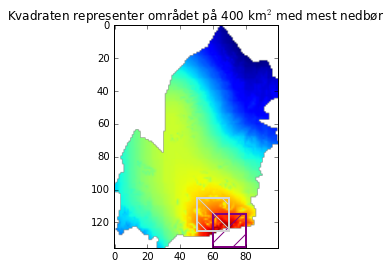

In [277]:
plt.imshow(precip, aspect='equal')
plt.gca().add_patch(Rectangle((med_j, med_i), window_x, window_y, hatch='/', fill=False, edgecolor='purple', linewidth=2))
plt.gca().add_patch(Rectangle((max_j, max_i), window_x, window_y, hatch='\\', fill=False, edgecolor='lightgrey', linewidth=2))
# the max will be unchanged in a neighboring window with a potentially higher median and not update its position - it can be removed. 
plt.title("Kvadraten representer området på {0} km$^2$ med mest nedbør".format(window_x*window_y))

### 2nd example

In [278]:
nc = Dataset("../data/met_obs_grid/rr_2017_01_07.nc", "r")

time_var = nc.variables['time']
precip_var = nc.variables['precipitation_amount']

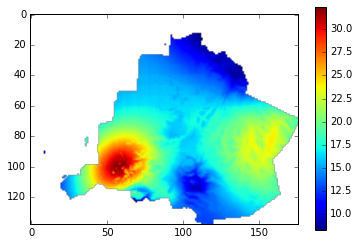

In [279]:
# Svartisen
region_mask = np.where(regions==3017)
# get the lower left and upper right corner of a rectangle around the region
y_min, y_max, x_min, x_max = min(region_mask[0].flatten()), max(region_mask[0].flatten()), min(region_mask[1].flatten()), max(region_mask[1].flatten())

x1, x2 = x_min, x_max # possible to add a buffer of step_x
y1, y2 = y_min, y_max # possible to add a buffer of step_y

precip = precip_var[0, y1:y2, x1:x2]

region_mask = regions[y1:y2, x1:x2] # redefine region_mask, now clipped to area of interest

precip = np.ma.masked_where(region_mask!=3017, precip)

plt.imshow(precip, aspect='equal')
plt.colorbar()
plt.show()

0.0 0.0 13.1999998093 17.3999996185 32.4000015259


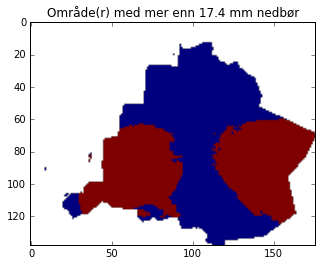

In [280]:
flier_low, box_bot, box_center, box_top, flier_high = regional_precip(precip)
print(flier_low, box_bot, box_center, box_top, flier_high)

precip_high = np.greater(precip, box_top) # mark region of precip over threshold
plt.imshow(precip_high, aspect='equal')
plt.title("Område(r) med mer enn {0:.1f} mm nedbør".format(box_top))

23.7000007629 27.8999996185 29.6000003815 30.7000007629 32.4000015259 90 50


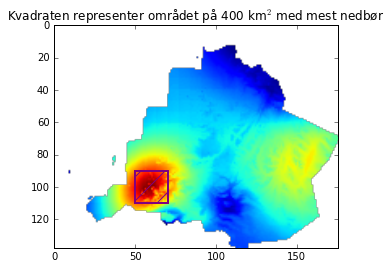

In [281]:
highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j = regional_precip_max(precip)        
print(highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j)

plt.imshow(precip, aspect='equal')
plt.gca().add_patch(Rectangle((med_j, med_i), window_x, window_y, hatch='/', fill=False, edgecolor='purple', linewidth=2))
#plt.gca().add_patch(Rectangle((max_j, max_i), window_x, window_y, hatch='\\', fill=False, edgecolor='red', linewidth=2))
# the max will be unchanged in a neighboring window with a potentially higher median and not update its position - it can be removed. 
plt.title("Kvadraten representer området på {0} km$^2$ med mest nedbør".format(window_x*window_y))

### 3rd example

In [282]:
nc = Dataset("../data/met_obs_grid/rr_2016_12_31.nc", "r")

time_var = nc.variables['time']
precip_var = nc.variables['precipitation_amount']

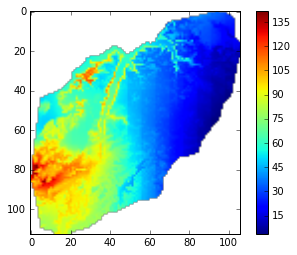

In [283]:
# Hardanger
region_mask = np.where(regions==3034)
# get the lower left and upper right corner of a rectangle around the region
y_min, y_max, x_min, x_max = min(region_mask[0].flatten()), max(region_mask[0].flatten()), min(region_mask[1].flatten()), max(region_mask[1].flatten())

x1, x2 = x_min, x_max # possible to add a buffer of step_x
y1, y2 = y_min, y_max # possible to add a buffer of step_y

precip = precip_var[0, y1:y2, x1:x2]

region_mask = regions[y1:y2, x1:x2] # redefine region_mask, now clipped to area of interest

precip = np.ma.masked_where(region_mask!=3034, precip)

plt.imshow(precip, aspect='equal')
plt.colorbar()
plt.show()

0.10000000149 23.3999996185 47.7999992371 68.5 142.0


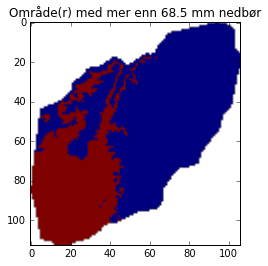

In [284]:
flier_low, box_bot, box_center, box_top, flier_high = regional_precip(precip)
print(flier_low, box_bot, box_center, box_top, flier_high)

precip_high = np.greater(precip, box_top) # mark region of precip over threshold
plt.imshow(precip_high, aspect='equal')
plt.title("Område(r) med mer enn {0:.1f} mm nedbør".format(box_top))

83.9000015259 101.099998474 106.699996948 114.850002289 142.0 75 0


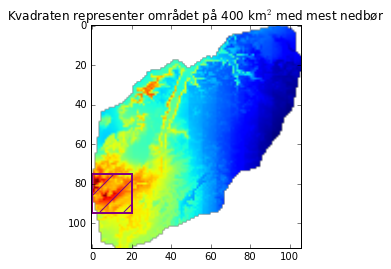

In [285]:
highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j = regional_precip_max(precip)        
print(highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j)

plt.imshow(precip, aspect='equal')
plt.gca().add_patch(Rectangle((med_j, med_i), window_x, window_y, hatch='/', fill=False, edgecolor='purple', linewidth=2))
#plt.gca().add_patch(Rectangle((max_j, max_i), window_x, window_y, hatch='\\', fill=False, edgecolor='red', linewidth=2))
# the max will be unchanged in a neighboring window with a potentially higher median and not update its position - it can be removed. 
plt.title("Kvadraten representer området på {0} km$^2$ med mest nedbør".format(window_x*window_y))

### Live example

In [291]:
region_id = 3031
year = 2017; month= 1; day=7

nc = Dataset(r"Y:\metdata\met_obs_v2.0\rr\{yyyy}\rr_{yyyy}_{mm:02}_{dd:02}.nc".format(yyyy=year, mm=month, dd=day), "r")

time_var = nc.variables['time']
precip_var = nc.variables['precipitation_amount']

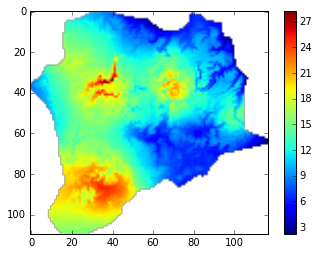

In [292]:
region_mask = np.where(regions==region_id)
# get the lower left and upper right corner of a rectangle around the region
y_min, y_max, x_min, x_max = min(region_mask[0].flatten()), max(region_mask[0].flatten()), min(region_mask[1].flatten()), max(region_mask[1].flatten())

x1, x2 = x_min, x_max # possible to add a buffer of step_x
y1, y2 = y_min, y_max # possible to add a buffer of step_y

precip = precip_var[0, y1:y2, x1:x2]

region_mask = regions[y1:y2, x1:x2] # redefine region_mask, now clipped to area of interest

precip = np.ma.masked_where(region_mask!=region_id, precip)

plt.imshow(precip, aspect='equal')
plt.colorbar()
plt.show()

[0.10000000149011612, 6.800000190734863, 11.5, 15.399999618530273, 28.299999237060547]


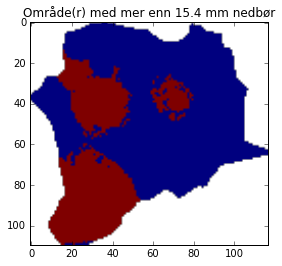

In [293]:
flier_low, box_bot, box_center, box_top, flier_high = regional_precip(precip)
print("[{0}, {1}, {2}, {3}, {4}]".format(flier_low, box_bot, box_center, box_top, flier_high))

precip_high = np.greater(precip, box_top) # mark region of precip over threshold
plt.imshow(precip_high, aspect='equal')
plt.title("Område(r) med mer enn {0:.1f} mm nedbør".format(box_top))
plt.savefig(r"D:\Dev\APs\viz\resources\precip_thresh.png")

[16.0, 19.0, 21.299999237060547, 22.924999713897705, 25.0] - (75, 25)


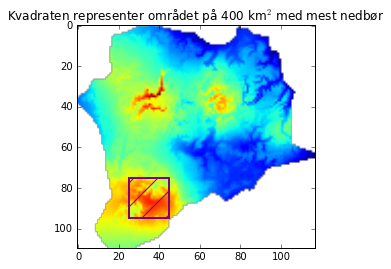

In [294]:
highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j = regional_precip_max(precip)        
print("[{0}, {1}, {2}, {3}, {4}] - ({5}, {6})".format(highest_med_low, highest_med_bot, highest_med_center, highest_med_top, highest_med_high, med_i, med_j))

plt.imshow(precip, aspect='equal')
plt.gca().add_patch(Rectangle((med_j, med_i), window_x, window_y, hatch='/', fill=False, edgecolor='purple', linewidth=2))
#plt.gca().add_patch(Rectangle((max_j, max_i), window_x, window_y, hatch='\\', fill=False, edgecolor='red', linewidth=2))
# the max will be unchanged in a neighboring window with a potentially higher median and not update its position - it can be removed. 
plt.title("Kvadraten representer området på {0} km$^2$ med mest nedbør".format(window_x*window_y))
plt.savefig(r"D:\Dev\APs\viz\resources\precip_high.png")

## Clustering

### Spectral clustering

In [258]:
print(__doc__)

# Authors:  Emmanuelle Gouillart <emmanuelle.gouillart@normalesup.org>
#           Gael Varoquaux <gael.varoquaux@normalesup.org>
# License: BSD 3 clause

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

Automatically created module for IPython interactive environment


Generate sample data

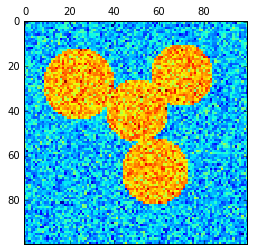

In [259]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

plt.matshow(img)

Compute clustering with Spectral clustering

In [260]:
#graph = np.double(precip)

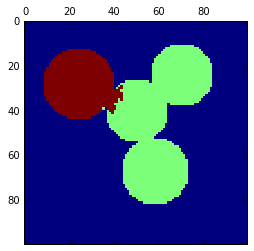

In [261]:
# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.matshow(label_im)

### Affinity propagation

In [37]:
print(__doc__)

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

Automatically created module for IPython interactive environment


Generate sample data

In [53]:
from sklearn.datasets.samples_generator import make_blobs

In [54]:
centers = [[1, 1], [-1, -1], [1, -1]]
precip, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

Compute Affinity propagation

In [56]:
af = AffinityPropagation(preference=-50.).fit(precip)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(precip, labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Silhouette Coefficient: 0.753


Plot results

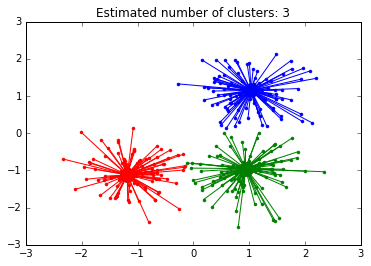

In [57]:
#import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = precip[cluster_centers_indices[k]]
    plt.plot(precip[class_members, 0], precip[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in precip[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()